### Download Dataset

In [1]:
%%sh
#!/bin/bash
pip install gdown
pip install keras-tuner
if [ -e depression_dataset_reddit_cleaned.csv ]
then
    echo "Data set already available."
else
    echo "Downloading data set."
    gdown 1jsuygnZ3G6R2lam5huSKBNXOFMCByWz9
fi
if [ -e glove.6B.zip ]
then
    echo "Glove zip already available."
else
    echo "Downloading glove zip."
    wget https://nlp.stanford.edu/data/glove.6B.zip
    unzip -j glove.6B.zip -d ./
fi

# gdown 1jsuygnZ3G6R2lam5huSKBNXOFMCByWz9
# wget https://nlp.stanford.edu/data/glove.6B.zip
# unzip -j glove.6B.zip -d ./

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.7 MB/s eta 0:00:00
Archive:  glove.6B.zip
  inflating: ./glove.6B.50d.txt      
  inflating: ./glove.6B.100d.txt     
  inflating: ./glove.6B.200d.txt     
  inflating: ./glove.6B.300d.txt     


Downloading...
From: https://drive.google.com/uc?id=1jsuygnZ3G6R2lam5huSKBNXOFMCByWz9
To: /content/depression_dataset_reddit_cleaned.csv
100%|██████████| 2.82M/2.82M [00:00<00:00, 67.1MB/s]
--2023-02-01 00:04:46--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-01 00:04:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

     0K .......... .......... .......... .......... ..........  0%  285K 49m19

In [2]:
import os
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.models import load_model
from keras.optimizers import RMSprop
from keras_tuner import Hyperband
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from tensorflow.config import list_physical_devices
list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
data_set_df = pd.read_csv('depression_dataset_reddit_cleaned.csv')

In [6]:
data_set_df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [7]:
data_set_df.isnull().values.any()

False

In [8]:
data_set_df.shape

(7731, 2)

In [9]:
data_set_df["clean_text"][10]

'i ve been struggling with depression for a long time now but i just my first severe instance of depersonalization and it scared me so badly i m not even entirely sure why but something about the fact that i just spent over an hour lying on the floor feeling like my body didn t really belong to me and i might not be real is so extremely unsettling to me i feel more mentally and physically myself now and just trying to process what happened is really difficult if anyone ha any kind of comfort or advice about depersonalization i d appreciate it'

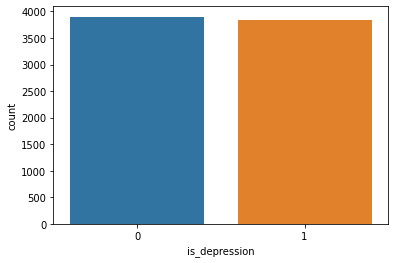

In [10]:
sns.countplot(x='is_depression', data=data_set_df)

### Pre-processing of text
- Removing html tags
- Removing punctutations and numbers
- Removing Multiple spaces
- so on

In [11]:
stop_words = stopwords.words('english') #English language's stop words

def textpreprocess(s):
    """This function cleans the text
    Input: string to be cleaned
    Return: string after cleaning
    """
    words = [] # empty list
    
    s = s.strip().lower() # lower the string
    s = re.sub('\[.*?\]', '', s) # removes symbols (.*?\)
    s = re.sub('https?://\S+|www\.\S+', '', s) # remove URLS
    s = re.sub('<.*?>+', '', s)
    s = re.sub('[%s]' % re.escape(string.punctuation), '', s) # remove punctuations
    s = re.sub('\n', '', s) # remove next line character
    s = re.sub('\w*\d\w*', '', s)
    
    words = s.split() # split the string into list of words
    words = [word for word in words if word not in stop_words] # removing stop words
    s = ' '.join(words) # converting list to string
    
    return s

In [12]:
X = []
sentences = list(data_set_df['clean_text'])
for sen in sentences:
    X.append(textpreprocess(sen))

In [13]:
X[10]

'struggling depression long time first severe instance depersonalization scared badly even entirely sure something fact spent hour lying floor feeling like body really belong might real extremely unsettling feel mentally physically trying process happened really difficult anyone ha kind comfort advice depersonalization appreciate'

In [14]:
y = np.asarray(data_set_df['is_depression']).astype('float32').reshape((-1,1))
y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

### Split the dataset to train and test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Use Tokenizer to integer encode the documents

In [16]:
num_words_ = 5000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=num_words_, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### Pad Sequences to create equal-length inputs

In [17]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 500
trunc_type='post'
padding_type='post'

X_train = pad_sequences(X_train, maxlen=maxlen, truncating= trunc_type, padding=padding_type)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Load GloVe embedding into memory

In [18]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

### Create Embedding matrix for our Kaggle dataset

In [19]:
embedding_matrix = np.zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Build the model - Long Short Term Memory Neural Network

In [20]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           825150    
                                                                 
 lstm (LSTM)                 (None, 500, 128)          91648     
                                                                 
 lstm_1 (LSTM)               (None, 500, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 979,167
Trainable params: 154,017
Non-trai

### Fit the model

In [22]:
if os.path.isfile('model.h5'):
  model = load_model('model.h5')
  history = pd.read_csv('history.csv')
else:
  history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_split=0.1)
  history = pd.DataFrame(history.history)

### Evaluate Training phase

In [23]:
score = model.evaluate(X_train, y_train, verbose=1)
score

194/194 [==============================] - 11s 32ms/step - loss: 0.0986 - accuracy: 0.9701


[0.09859208017587662, 0.9700840711593628]

In [24]:
print("Train Loss:", score[0])
print("Train Accuracy:", score[1])

Train Loss: 0.09859208017587662
Train Accuracy: 0.9700840711593628


### Evaluate Testing phase

In [25]:
score = model.evaluate(X_test, y_test, verbose=1)
score

49/49 [==============================] - 2s 40ms/step - loss: 0.1422 - accuracy: 0.9541


[0.142169788479805, 0.9541047215461731]

In [26]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.142169788479805
Test Accuracy: 0.9541047215461731


In [27]:
X_test

array([[ 257,   22,    1, ...,    0,    0,    0],
       [ 546,   14, 3876, ...,    0,    0,    0],
       [  25,  643,    8, ...,    0,    0,    0],
       ...,
       [   4,  655,  446, ...,    0,    0,    0],
       [ 726,  220, 1535, ...,    0,    0,    0],
       [ 127,   25,  172, ...,    0,    0,    0]], dtype=int32)

In [28]:
y_test_pred = model.predict(X_test)
y_test_pred

49/49 [==============================] - 4s 38ms/step


array([[0.9958289 ],
       [0.99509513],
       [0.99585116],
       ...,
       [0.9958539 ],
       [0.99582905],
       [0.02748694]], dtype=float32)

In [29]:
y_test_pred = (y_test_pred > 0.5).astype("int32")
y_test_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [30]:
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred) 
confusion_matrix

array([[752,  31],
       [ 40, 724]])

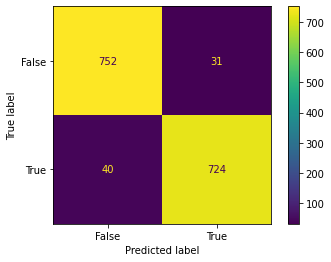

In [31]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 
cm_display.plot()
plt.show() 

### Plot the training and testing accuracy and loss

In [32]:
history

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,0.694509,0.499730,0.691948,0.520194
1,1,0.694402,0.495058,0.697934,0.483037
2,2,0.694073,0.492543,0.692276,0.520194
3,3,0.692681,0.511051,0.688394,0.520194
4,4,0.698462,0.513208,0.692181,0.500808
...,...,...,...,...,...
95,95,0.133546,0.964061,0.649509,0.852989
96,96,0.251805,0.926505,0.170386,0.951535
97,97,0.097450,0.972147,0.179713,0.946688
98,98,0.120309,0.965678,0.178155,0.948304


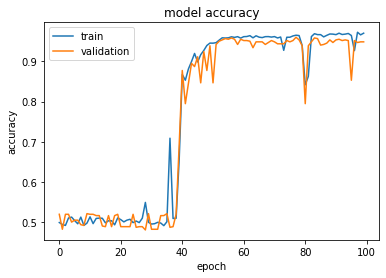

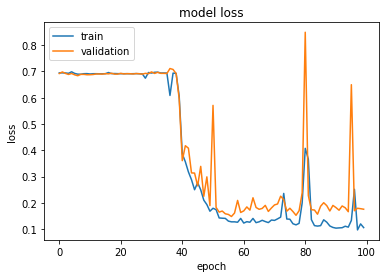

In [33]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

### Save Model

In [34]:
if not os.path.isfile('model.h5'):
  model.save('model.h5', save_format='h5')
  history.to_csv('history.csv',header=True)

### Hypertuning with Keras Tuner

#### Define the model architecture

In [35]:
def hypertune_model(hp):
    """
    Builds model and sets up hyperparameter space to search.
    
    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.
        
    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    # Initialize sequential API and start building model.
    model = Sequential()
    model.add(embedding_layer)
    
    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 5
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("lstm_num_layers", 2, 6)):
        model.add(
            LSTM(hp.Int("lstm_units_" + str(i), min_value=32, max_value=512, step=32),
                       activation='tanh', 
                       return_sequences=True)
            )
    
    for i in range(1, hp.Int("dense_num_layers", 1, 3)):
        model.add(
            Dense(hp.Int("dense_units_" + str(i), min_value=32, max_value=64, step=16),
                       activation='sigmoid')
            )
    
    # Add output layer.
    model.add(Dense(units=1, activation="sigmoid"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=RMSprop(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=["accuracy"])
    
    return model

In [36]:
tuner = Hyperband(hypertune_model,
                     objective="val_accuracy",
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=10,
                     directory='hypertuning',
                     seed=12,
                     project_name='hypertuned_model',)

In [37]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
lstm_num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
lstm_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dense_num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [38]:
if not os.path.isfile('hypertuned_model.h5'):
  stop_early = EarlyStopping(monitor='val_loss', patience=5)
  tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early], verbose=2)
  
  best_hyperparams_all = tuner.get_best_hyperparameters()
  
  # Build model
  hypertuned_best_model = tuner.hypermodel.build(best_hyperparams_all[0])

  # Train the hypertuned model
  hypertuned_history = hypertuned_best_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early], verbose=2)
  hypertuned_history = pd.DataFrame(hypertuned_history.history)
else:
  hypertuned_best_model = Sequential()
  embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
  hypertuned_best_model.add(embedding_layer)
  hypertuned_best_model.add(LSTM(480, activation='tanh', return_sequences=True))
  hypertuned_best_model.add(LSTM(32, activation='tanh', return_sequences=True))
  hypertuned_best_model.add(LSTM(160, activation='tanh', return_sequences=True))
  hypertuned_best_model.add(Dense(1, activation='sigmoid'))
  hypertuned_best_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  hypertuned_best_model = load_model('hypertuned_model.h5')
  hypertuned_history = pd.read_csv('hypertuned_history.csv')

In [39]:
hypertuned_best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 50)           825150    
                                                                 
 lstm_4 (LSTM)               (None, 500, 480)          1019520   
                                                                 
 lstm_5 (LSTM)               (None, 500, 32)           65664     
                                                                 
 lstm_6 (LSTM)               (None, 500, 160)          123520    
                                                                 
 dense_2 (Dense)             (None, 500, 1)            161       
                                                                 
Total params: 2,034,015
Trainable params: 1,208,865
Non-trainable params: 825,150
_________________________________________________________________


### Save the best hypertuned model

In [40]:
if not os.path.isfile('hypertuned_model.h5'):
  hypertuned_best_model.save('hypertuned_model.h5', save_format='h5')
  hypertuned_history.to_csv('hypertuned_history.csv',header=True)

In [41]:
# ! zip -r hypertuning.zip hypertuning

### Evaluate Training phase for Best Model

In [42]:
score = hypertuned_best_model.evaluate(X_train, y_train, verbose=1)
score

194/194 [==============================] - 14s 56ms/step - loss: 0.0397 - accuracy: 0.9919


[0.039728403091430664, 0.9919441342353821]

In [43]:
print("Train Loss:", score[0])
print("Train Accuracy:", score[1])

Train Loss: 0.039728403091430664
Train Accuracy: 0.9919441342353821


### Evaluate Testing phase for Best Model

In [44]:
score = hypertuned_best_model.evaluate(X_test, y_test, verbose=1)
score

49/49 [==============================] - 2s 35ms/step - loss: 0.2432 - accuracy: 0.9558


[0.24318049848079681, 0.9558421969413757]

In [45]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.24318049848079681
Test Accuracy: 0.9558421969413757


In [46]:
X_test

array([[ 257,   22,    1, ...,    0,    0,    0],
       [ 546,   14, 3876, ...,    0,    0,    0],
       [  25,  643,    8, ...,    0,    0,    0],
       ...,
       [   4,  655,  446, ...,    0,    0,    0],
       [ 726,  220, 1535, ...,    0,    0,    0],
       [ 127,   25,  172, ...,    0,    0,    0]], dtype=int32)

In [50]:
y_test_pred = hypertuned_best_model.predict(X_test).mean(axis=1)
y_test_pred

49/49 [==============================] - 3s 53ms/step


array([[9.978203e-01],
       [9.991311e-01],
       [9.946677e-01],
       ...,
       [9.986151e-01],
       [9.974534e-01],
       [8.370409e-04]], dtype=float32)

In [51]:
y_test_pred = (y_test_pred > 0.5).astype("int32")
y_test_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [52]:
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred) 
confusion_matrix

array([[755,  28],
       [ 36, 728]])

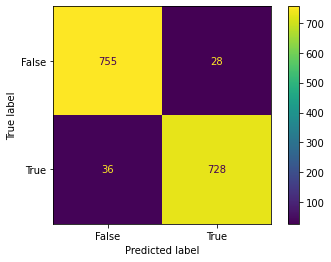

In [53]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 
cm_display.plot()
plt.show() 

### Plot the training and testing accuracy and loss

In [54]:
hypertuned_history

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,0.690082,0.619297,0.660372,0.579460
1,1,0.576823,0.710932,0.383965,0.866094
2,2,0.559547,0.717141,0.507367,0.774672
3,3,0.376507,0.877187,0.357820,0.887334
4,4,0.433718,0.834862,0.271400,0.920727
...,...,...,...,...,...
95,95,0.012210,0.995546,0.341278,0.943887
96,96,0.013227,0.995532,0.298907,0.948501
97,97,0.011546,0.995908,0.321342,0.944727
98,98,0.009065,0.996582,0.331830,0.945199


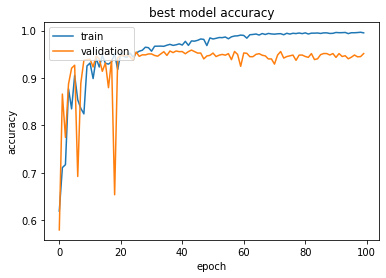

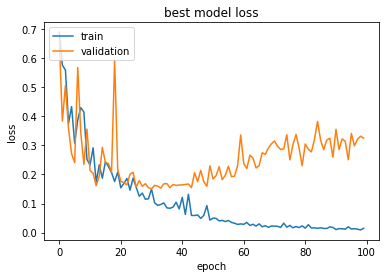

In [55]:
plt.plot(hypertuned_history['accuracy'])
plt.plot(hypertuned_history['val_accuracy'])

plt.title('best model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(hypertuned_history['loss'])
plt.plot(hypertuned_history['val_loss'])

plt.title('best model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

### Testing with random sentances

In [80]:
def predict_with_best_model(comment:str):
  comment = textpreprocess(comment)
  arr = tokenizer.texts_to_sequences([comment])
  arr = pad_sequences(arr, maxlen=maxlen, truncating= trunc_type, padding=padding_type)
  return (hypertuned_best_model.predict([arr],verbose=0).mean(axis=1)>0.5).astype("bool")[0][0]

In [77]:
def predict(comment:str):
  comment = textpreprocess(comment)
  arr = tokenizer.texts_to_sequences([comment])
  arr = pad_sequences(arr, maxlen=maxlen, truncating= trunc_type, padding=padding_type)
  return (model.predict([arr],verbose=0)>0.5).astype("bool")[0][0]

In [78]:
predict("""I've been struggling with depression for a 
          long time now but I just my first severe instance 
          of depersonalization and it scared me so badly i m not 
          even entirely sure why but something about the fact that 
          i just spent over an hour lying on the floor feeling like 
          my body didn t really belong to me and i might not be real 
          is so extremely unsettling to me i feel more mentally.""")

True

In [81]:
predict_with_best_model("""I've been struggling with depression for a 
          long time now but I just my first severe instance 
          of depersonalization and it scared me so badly i m not 
          even entirely sure why but something about the fact that 
          i just spent over an hour lying on the floor feeling like 
          my body didn t really belong to me and i might not be real 
          is so extremely unsettling to me i feel more mentally.""")

True

In [82]:
predict("""I am really happy.""")

False

In [83]:
predict_with_best_model("""I am really happy.""")

False

In [87]:
predict("""I feel like dying as everyone make me feel like shit.""")

True

In [86]:
predict_with_best_model("""I feel like dying as everyone make me feel like shit.""")

True